In [8]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [57]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

In [88]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_73403/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [89]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = [col.lower().replace(" ", "_").replace("-", "_").replace("itchiness/irritation_in_eye", 'eye_irritation') for col in df.columns]

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)

In [90]:
omit_cols = ['blood_pressure',
              'systolic',
              'diastolic']
df = df.drop(columns=omit_cols)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   20000 non-null  object 
 1   age                      20000 non-null  int64  
 2   sleep_duration           20000 non-null  float64
 3   sleep_quality            20000 non-null  int64  
 4   stress_level             20000 non-null  int64  
 5   heart_rate               20000 non-null  int64  
 6   daily_steps              20000 non-null  int64  
 7   physical_activity        20000 non-null  int64  
 8   height                   20000 non-null  int64  
 9   weight                   20000 non-null  int64  
 10  sleep_disorder           20000 non-null  object 
 11  wake_up_during_night     20000 non-null  object 
 12  feel_sleepy_during_day   20000 non-null  object 
 13  caffeine_consumption     20000 non-null  object 
 14  alcohol_consumption   

In [92]:
df.head(20)

,gender,age,sleep_duration,sleep_quality,stress_level,heart_rate,daily_steps,physical_activity,height,weight,...,medical_issue,ongoing_medication,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,dry_eye_disease,bp_category
0,F,24,9.5,2,1,67,3000,31,161,69,...,Y,Y,N,8.7,N,Y,Y,N,Y,high
1,M,39,9.6,2,3,60,12000,74,164,87,...,Y,Y,N,9.6,Y,N,N,Y,Y,low
2,F,45,5.4,1,5,95,12000,93,179,94,...,N,N,Y,4.0,N,Y,N,N,N,high
3,F,45,5.4,4,5,78,19000,32,160,77,...,Y,N,N,7.6,N,Y,N,Y,N,high
4,F,42,5.7,3,2,72,4000,173,179,99,...,Y,N,N,3.5,N,Y,Y,N,Y,low
5,F,42,5.8,3,1,79,14000,110,174,64,...,Y,Y,Y,2.6,Y,Y,N,Y,Y,high
6,M,26,4.8,5,2,63,6000,42,188,82,...,Y,Y,Y,5.4,Y,N,N,Y,Y,high
7,M,33,5.5,2,1,97,5000,71,162,91,...,N,Y,N,4.5,Y,Y,N,N,Y,high
8,M,36,6.3,1,2,78,7000,142,175,80,...,Y,N,N,3.9,Y,N,N,Y,N,high
9,M,33,7.7,4,5,81,4000,105,163,65,...,Y,Y,N,5.7,N,N,Y,Y,Y,high


In [93]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
for col in categorical_features:
    df[col] = df[col].str.lower()
print(df.iloc[1999])

gender                         m
age                           41
sleep_duration               8.2
sleep_quality                  4
stress_level                   2
heart_rate                    85
daily_steps                11000
physical_activity             48
height                       179
weight                        61
sleep_disorder                 y
wake_up_during_night           n
feel_sleepy_during_day         n
caffeine_consumption           n
alcohol_consumption            n
smoking                        n
medical_issue                  n
ongoing_medication             n
smart_device_before_bed        y
average_screen_time          2.2
blue_light_filter              y
discomfort_eye_strain          n
redness_in_eye                 n
eye_irritation                 y
dry_eye_disease                y
bp_category                 high
Name: 1999, dtype: object


In [94]:
# def define_insomnia(row):
#     criteria_met = 0
    
#     # Check if each criterion is met
#     if row['sleep_disorder'] == 'y':  # Only consider those with sleep disorder
#         criteria_met+=1
#     if row['sleep_duration'] < 6:
#             criteria_met += 1
#     if row['sleep_quality'] <= 2:
#         criteria_met += 1
#     if row['feel_sleepy_during_day'] == 'y':
#         criteria_met += 1
#     if row['wake_up_during_night'] == 'y':
#         criteria_met += 1
    
#     # Assign insomnia as 1 if 2 or more criteria are met
#     if criteria_met >= 3:
#         return 1
#     return 0  # Insomnia = 0 if fewer than 2 criteria are met

# # Apply the function to create a new column 'Insomnia'
# df['insomnia'] = df.apply(define_insomnia, axis=1)

In [95]:
# df.insomnia.value_counts()

In [96]:
def classify_group(row):
    if row['dry_eye_disease'] == 'y' and row['sleep_disorder'] == 'y':
        return '1'  # Group A: both
    elif row['dry_eye_disease'] == 'y' and row['sleep_disorder'] == 'n':
        return '2'  # Group B: only ded
    elif row['dry_eye_disease'] == 'n' and row['sleep_disorder'] == 'y':
        return '3'  # Group C: only sleep_disorder
    else:
        return '4'  # Group D: none

df['ded_disorder_group'] = df.apply(classify_group, axis=1)

In [97]:
df['ded_disorder_group'].value_counts()

ded_disorder_group
2    6551
1    6486
4    3518
3    3445
Name: count, dtype: int64

In [98]:
6551/20000

0.32755

In [99]:
df

,gender,age,sleep_duration,sleep_quality,stress_level,heart_rate,daily_steps,physical_activity,height,weight,...,ongoing_medication,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,dry_eye_disease,bp_category,ded_disorder_group
0,f,24,9.5,2,1,67,3000,31,161,69,...,y,n,8.7,n,y,y,n,y,high,1
1,m,39,9.6,2,3,60,12000,74,164,87,...,y,n,9.6,y,n,n,y,y,low,2
2,f,45,5.4,1,5,95,12000,93,179,94,...,n,y,4.0,n,y,n,n,n,high,3
3,f,45,5.4,4,5,78,19000,32,160,77,...,n,n,7.6,n,y,n,y,n,high,4
4,f,42,5.7,3,2,72,4000,173,179,99,...,n,n,3.5,n,y,y,n,y,low,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,m,26,9.4,2,3,91,20000,88,200,72,...,y,y,3.8,n,y,n,y,y,high,2
19996,f,39,7.3,3,4,65,2000,53,195,96,...,y,n,3.8,n,n,y,n,y,low,1
19997,f,20,8.0,5,3,78,10000,17,186,87,...,n,n,8.4,n,n,y,n,n,high,4
19998,m,38,4.5,3,3,60,3000,115,170,66,...,y,n,2.2,n,n,n,y,y,high,2


In [100]:
# ded = {'n' : 0,
#         'y' : 1
#       }
# df.dry_eye_disease = df.dry_eye_disease.map(ded)

## Since here we want predict both sleep disorder and ded from other factors, we have to drop these 2 and only keep the joint target variable.

In [101]:
cols_to_drop = ['sleep_disorder', 'dry_eye_disease']

df1 = df.drop(cols_to_drop, axis=1) #df1: no columns having ded/insomnia/insomnia definition features
df1


,gender,age,sleep_duration,sleep_quality,stress_level,heart_rate,daily_steps,physical_activity,height,weight,...,medical_issue,ongoing_medication,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,bp_category,ded_disorder_group
0,f,24,9.5,2,1,67,3000,31,161,69,...,y,y,n,8.7,n,y,y,n,high,1
1,m,39,9.6,2,3,60,12000,74,164,87,...,y,y,n,9.6,y,n,n,y,low,2
2,f,45,5.4,1,5,95,12000,93,179,94,...,n,n,y,4.0,n,y,n,n,high,3
3,f,45,5.4,4,5,78,19000,32,160,77,...,y,n,n,7.6,n,y,n,y,high,4
4,f,42,5.7,3,2,72,4000,173,179,99,...,y,n,n,3.5,n,y,y,n,low,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,m,26,9.4,2,3,91,20000,88,200,72,...,y,y,y,3.8,n,y,n,y,high,2
19996,f,39,7.3,3,4,65,2000,53,195,96,...,y,y,n,3.8,n,n,y,n,low,1
19997,f,20,8.0,5,3,78,10000,17,186,87,...,y,n,n,8.4,n,n,y,n,high,4
19998,m,38,4.5,3,3,60,3000,115,170,66,...,n,y,n,2.2,n,n,n,y,high,2


In [104]:
X = df.drop(columns=['ded_disorder_group'])
y = df['ded_disorder_group']

In [103]:
df_full_train, df_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, stratify=y, random_state=1)

InvalidParameterError: The 'stratify' parameter of train_test_split must be an array-like or None. Got 'y' instead.

In [25]:
len(df_train), len(df_test), len(df_val)

(12000, 4000, 4000)

In [26]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [28]:
y_train = df_train['ded_disorder_group'].astype(int).values
y_val = df_val['ded_disorder_group'].astype(int).values
y_test = df_test['ded_disorder_group'].astype(int).values #.values converts pandas series to numpy array.

In [29]:
del df_train['ded_disorder_group']
del df_test['ded_disorder_group']
del df_val['ded_disorder_group']

In [30]:
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient= 'records')
test_dicts = df_test.to_dict(orient= 'records')

In [31]:
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

In [32]:
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [33]:
# ded_labels = {0: 'no', 1: 'yes'}

disease_labels = {1: 'both', 2: 'ded', 3: 'sleep_disorder', 4: 'none'}

In [36]:
classifers = {
              # 'Random Forest': RandomForestClassifier(max_depth =  10, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 500, random_state=3),
              'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=100, random_state=3, min_samples_leaf = 1),
              'SVM': SVC(random_state=3),
              'Decision Tree': DecisionTreeClassifier(random_state=3),
              'KNN': KNeighborsClassifier()
             }


Random Forest Classifier:
Training accuracy: 0.435
Cross-validation accuracy: 0.360 (+/- 0.015)
Validation accuracy: 0.350
Test accuracy: 0.351
Precision: 0.289
Recall: 0.351
F1-score: 0.311

Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.38      0.37      1318
           2       0.36      0.57      0.44      1291
           3       0.00      0.00      0.00       683
           4       0.33      0.24      0.28       708

    accuracy                           0.35      4000
   macro avg       0.26      0.30      0.27      4000
weighted avg       0.29      0.35      0.31      4000



/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

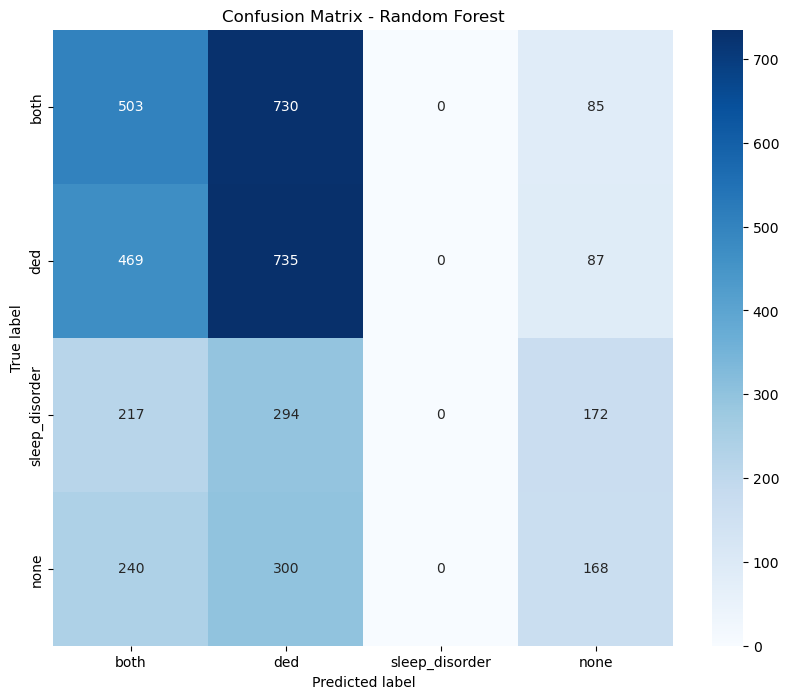


SVM Classifier:
Training accuracy: 0.329
Cross-validation accuracy: 0.324 (+/- 0.005)
Validation accuracy: 0.329
Test accuracy: 0.323
Precision: 0.104
Recall: 0.323
F1-score: 0.158

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1318
           2       0.32      1.00      0.49      1291
           3       0.00      0.00      0.00       683
           4       0.00      0.00      0.00       708

    accuracy                           0.32      4000
   macro avg       0.08      0.25      0.12      4000
weighted avg       0.10      0.32      0.16      4000



/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

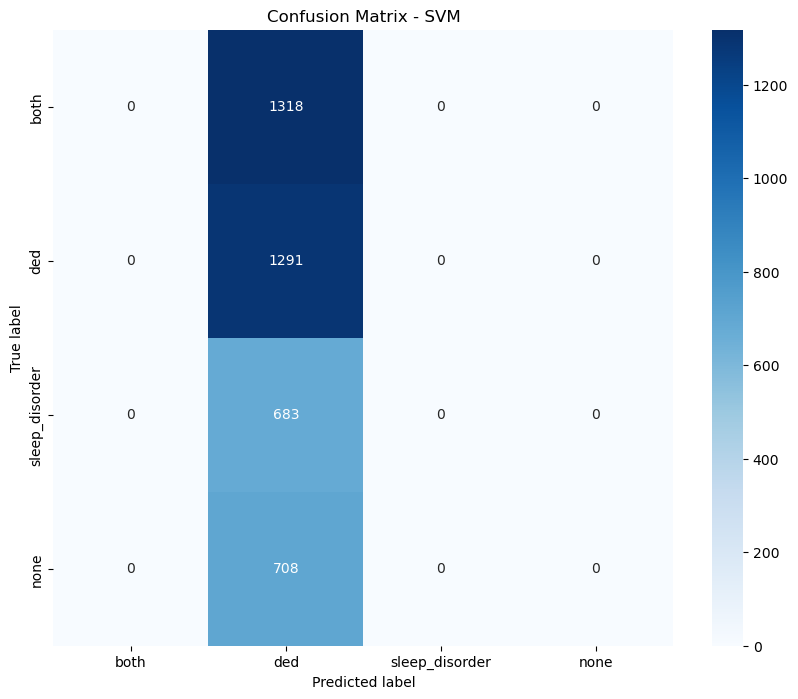


Decision Tree Classifier:
Training accuracy: 1.000
Cross-validation accuracy: 0.291 (+/- 0.008)
Validation accuracy: 0.276
Test accuracy: 0.281
Precision: 0.284
Recall: 0.281
F1-score: 0.282

Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.33      0.34      1318
           2       0.32      0.32      0.32      1291
           3       0.19      0.20      0.19       683
           4       0.19      0.19      0.19       708

    accuracy                           0.28      4000
   macro avg       0.26      0.26      0.26      4000
weighted avg       0.28      0.28      0.28      4000



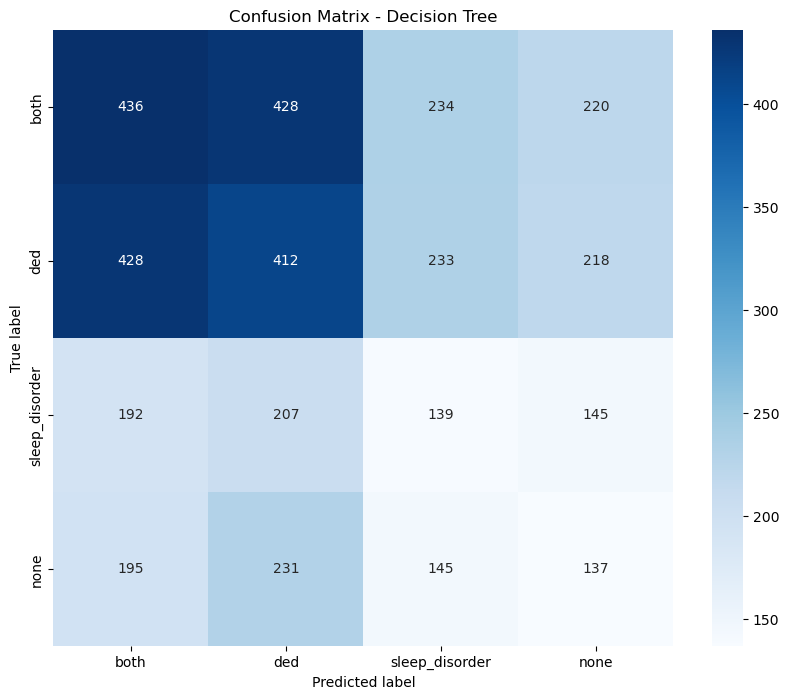


KNN Classifier:
Training accuracy: 0.518
Cross-validation accuracy: 0.296 (+/- 0.021)
Validation accuracy: 0.292
Test accuracy: 0.298
Precision: 0.271
Recall: 0.298
F1-score: 0.274

Classification Report:
              precision    recall  f1-score   support

           1       0.32      0.46      0.38      1318
           2       0.32      0.37      0.34      1291
           3       0.18      0.09      0.12       683
           4       0.17      0.07      0.10       708

    accuracy                           0.30      4000
   macro avg       0.25      0.25      0.24      4000
weighted avg       0.27      0.30      0.27      4000



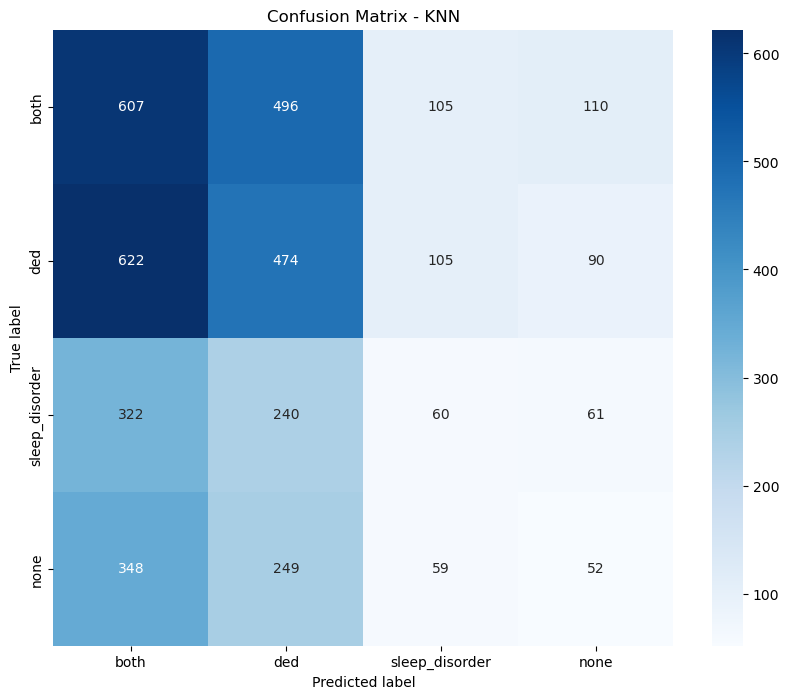

In [37]:
for name, clf in classifers.items():
    
    #5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=3)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
    
    #Fit the model
    
    clf.fit(X_train, y_train)

    #Predicting on training set

    y_pred_train = clf.predict(X_train)
    
    #Predicting on validation set
    
    y_pred_val = clf.predict(X_val)
    
    #Predicting on test set
    
    y_pred_test = clf.predict(X_test)
    
    #Evaluating from the metrics
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    #Calculating the precision, recall, F1-score
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Print results
    print(f"\n{name} Classifier:")
    print(f"Training accuracy: {train_accuracy:.3f}")
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Validation accuracy: {val_accuracy:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1_score:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
    
     # Plot confusion matrix with labels
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[disease_labels[i+1] for i in range(len(disease_labels))],
                yticklabels=[disease_labels[i+1] for i in range(len(disease_labels))])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 1. RANDOM FOREST

In [73]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Before SMOTE
print("Original class distribution:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# After SMOTE
print("Resampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({2: 3943, 1: 3886, 4: 2156, 3: 2015})
Resampled class distribution: Counter({2: 3943, 1: 3943, 3: 3943, 4: 3943})


In [83]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 500],
    'max_depth': [1, 2, 3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)



/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200, 250, 300, 500]},
             scoring='accuracy')

In [84]:
# Best parameters
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.4444749856042738


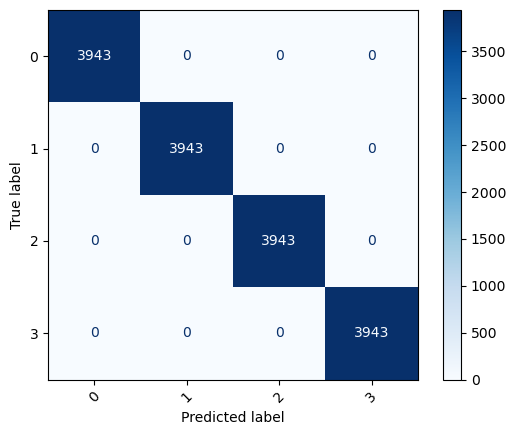

In [87]:
best_rf = grid_search_rf.best_estimator_
# Training accuracy
train_pred = best_rf.predict(X_train_resampled)
cm = confusion_matrix(y_train_resampled, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)

In [86]:
f1_macro_train = f1_score(y_train_resampled, train_pred, average='macro')
f1_weighted_train = f1_score(y_train_resampled, train_pred, average='weighted')

print("F1 Score (Macro), train:", round(f1_macro_train, 3))
print("F1 Score (Weighted):", round(f1_weighted_train, 3))

f1_macro_val = f1_score(y_test, val_pred, average='macro')
f1_weighted_val = f1_score(y_test, val_pred, average='weighted')

print("F1 Score (Macro), val:", round(f1_macro_val, 3))
print("F1 Score (Weighted):", round(f1_weighted_val, 3))

f1_macro_test = f1_score(y_test, test_pred, average='macro')
f1_weighted_test = f1_score(y_test, test_pred, average='weighted')

print("F1 Score (Macro), test:", round(f1_macro_test, 3))
print("F1 Score (Weighted):", round(f1_weighted_test, 3))

F1 Score (Macro), train: 1.0
F1 Score (Weighted): 1.0
F1 Score (Macro), val: 0.226
F1 Score (Weighted): 0.273
F1 Score (Macro), test: 0.275
F1 Score (Weighted): 0.317


In [52]:
# best_rf = grid_search_rf.best_estimator_
# # Training accuracy
# train_pred = best_rf.predict(X_train)
# train_acc = accuracy_score(y_train, train_pred)

# # Validation accuracy
# val_pred = best_rf.predict(X_val)
# val_acc = accuracy_score(y_val, val_pred)

# # Test accuracy
# test_pred = best_rf.predict(X_test)
# test_acc = accuracy_score(y_test, test_pred)

# print(f"Training Accuracy: {train_acc:.3f}")
# print(f"Validation Accuracy: {val_acc:.3f}")
# print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 0.417
Validation Accuracy: 0.354
Test Accuracy: 0.357


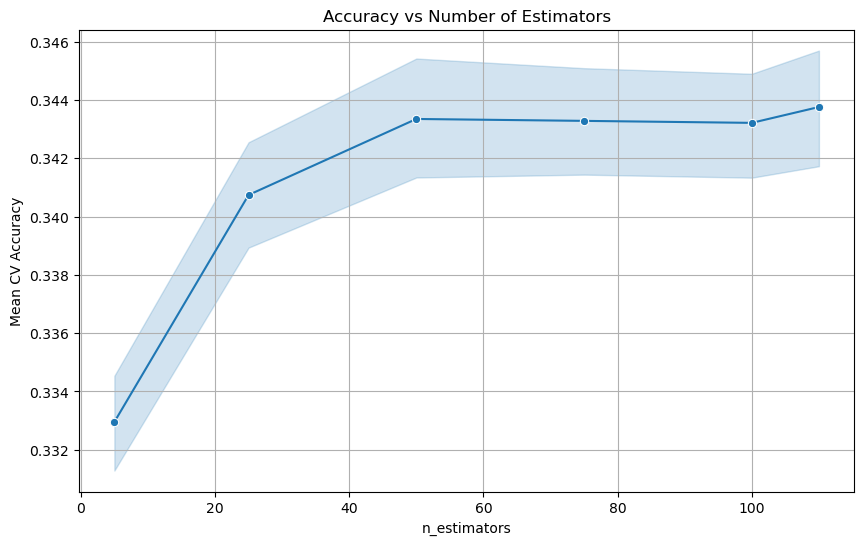

In [55]:
# # Extract cv results into DataFrame
# cv_results_df = pd.DataFrame(grid_search_rf.cv_results_)

# # Filter by one of the max_depths for plotting clarity (optional)
# # subset = cv_results_df[cv_results_df['param_max_depth'] == 10]

# # Plot accuracy vs n_estimators
# plt.figure(figsize=(10,6))
# sns.lineplot(data=cv_results_df, x='param_n_estimators', y='mean_test_score', marker='o')
# plt.title('Accuracy vs Number of Estimators')
# plt.xlabel('n_estimators')
# plt.ylabel('Mean CV Accuracy')
# plt.grid(True)
# plt.show()

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.05)
xgb.fit(X_train, y_train)
print(f"Train accuracy: {xgb.score(X_train, y_train):.3f}")
print(f"Test accuracy: {xgb.score(X_test, y_test):.3f}")

Train accuracy: 1.000
Test accuracy: 0.673
